In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station



In [8]:
# Create a session
# Link Python to the database by creating a SQLAlchemy session
# session = Session(engine)
from sqlalchemy.orm import Session
session = Session(bind=engine)

In [9]:
## Query station data
select_station_data = pd.read_sql("SELECT * FROM station", conn)

# Print station data
select_station_data.head()

,id,station,name,latitude,longitude,elevation
0,0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,0.914
1,1,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,4.450
2,2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,2.133
3,3,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,3.627
4,4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,93.447


In [10]:
## Query Measurement data
select_measurement_data = pd.read_sql("SELECT * FROM Measurement", conn)

# Print Measurement data
select_measurement_data.head()

,id,station,date,prcp,tobs
0,0,USC00519397,2010-01-01,2.0,18.3
1,1,USC00519397,2010-01-02,0.0,17.2
2,2,USC00519397,2010-01-03,0.0,23.3
3,3,USC00519397,2010-01-04,0.0,24.4
4,4,USC00519397,2010-01-06,NaN,22.8


# Exploratory Precipitation Analysis

In [11]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Find the most recent date in the data set.
# Latest Date
# session.query(Dow.date).order_by(Dow.date.desc()).first()
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

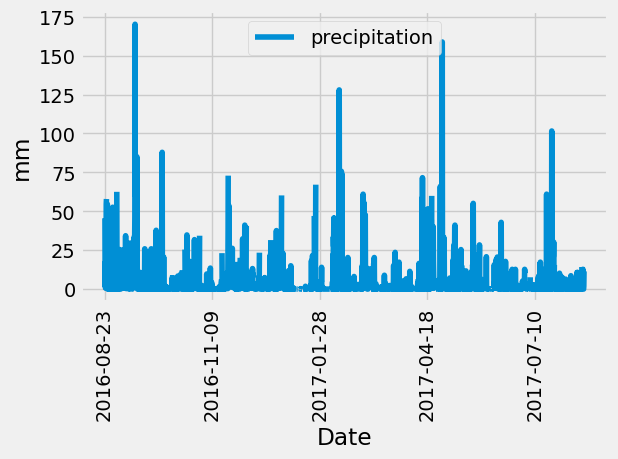

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

#* Consider using Pandas' [`to_datetimeto_datetime`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) method to convert the dates.

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date_str = most_recent_date[0] 

# Calculate the date one year from the last date in data set.

# Calculate it using to_datetime
most_recent_date_str_value = pd.to_datetime(most_recent_date_str).date()

last_year_date = most_recent_date_str_value - dt.timedelta(days=365)
last_year_date


# Perform a query to retrieve the data and precipitation scores
last_year_precipitation_data = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= last_year_date).all()
last_year_precipitation_data

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_precipitation_data_df = pd.DataFrame(last_year_precipitation_data, columns=['Date','precipitation'])

# Sort the dataframe by date
last_year_precipitation_data_df.set_index(last_year_precipitation_data_df['Date'], inplace=True)
last_year_precipitation_data_df = last_year_precipitation_data_df.sort_index()


# Use Pandas Plotting with Matplotlib to plot the data
last_year_precipitation_data_df.plot()
plt.xticks(rotation=90)
plt.ylabel("mm")
plt.yticks(range(0, int(last_year_precipitation_data_df['precipitation'].max() + 25), 25)) 
plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_precipitation_data_df.describe()

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all()

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_station_count = [Measurement.station,func.count(Measurement.station)]
query_active_station = session.query(*active_station_count).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
query_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# find active station id
active_station_id = query_active_station[0][0]
# query
min_max_avg = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]

min_max_avg_active_station = session.query(*min_max_avg).\
    filter(Measurement.station == active_station_id).all()
min_max_avg_active_station



[(12.2, 29.4, 22.035822510822513)]

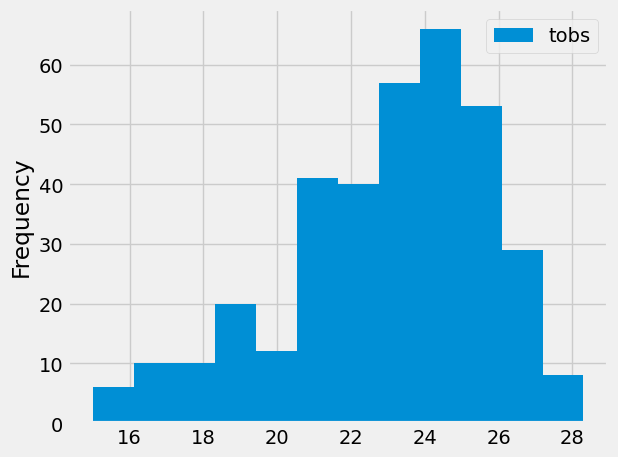

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# active station id - active_station_id
# last year date - last_year_date
temp_obs_data_active_station = session.query(Measurement.tobs).\
filter(Measurement.station == active_station_id).\
filter(Measurement.date >= last_year_date).all()

# print result
temp_obs_data_active_station

temp_obs_data_active_station_df = pd.DataFrame(temp_obs_data_active_station, columns=['tobs'])
temp_obs_data_active_station_df.plot.hist(bins=12)
plt.tight_layout()


# Close Session

In [19]:
# Close Session
session.close()
